In [23]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *

In [24]:
df, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

print("Creem diccionari")

##df = drop_all_columns(df, meta, df_variables, dict)

df = create_dataset(df, dict)

Creem diccionari


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[dict[num]] = np.where(df[dict[num]] == 5, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[dict[num]] = np.where(df[dict[num]] == 5, 1, 0)


In [25]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_net[col].fillna(mitjana, inplace=True)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [26]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  65  columnes


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2)


In [28]:
from sklearn.preprocessing import StandardScaler

## normalitzem les dades
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [29]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

## treim els coeficients que són 0
coef = pd.Series(lasso.coef_, index = df.drop(columns='temps_fins_reincidencia1a').columns)
print("Hem fet el model Lasso")
print("Hem trobat ", sum(coef == 0), " coeficients nuls")
print("Hem trobat ", sum(coef != 0), " coeficients no nuls")
## fem print dels que no són 0
print("Els coeficients no nuls són:")
print(coef[coef != 0])
## fem print dels coeficients nuls
print("Els coeficients nuls són:")
print(coef[coef == 0])



Hem fet el model Lasso
Hem trobat  13  coeficients nuls
Hem trobat  51  coeficients no nuls
Els coeficients no nuls són:
EdatAD                    102.672439
Niv_Esc                    77.198661
NSancGreu                -194.387315
NSancMGreu                224.323796
Total_Del                -217.402336
PCLe20                    323.505262
PCLe_PT                  -267.401509
PCLo_PT                   221.643615
PCLx_PT                   -99.897603
PCLj_PT                  -429.095835
PCLYVMPT                  476.319851
CAPEe_PT                 -788.288331
CAPEo_PT                 -186.750590
DDTotal                   432.333457
YSRTotProb                -36.530091
TRFTTotProb              -210.114571
VASTVic                    40.184829
VASTDir                   -27.539921
SD3Mach                  -155.231450
SD3Psyc                  -292.862329
SD3Narc                   -20.337637
SAVRYHis                 -106.326388
SAVRYSoc                  347.173470
SAVRYInd                 -21

c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.118e+04, tolerance: 1.762e+03
  model = cd_fast.enet_coordinate_descent(


In [30]:
# Definim un llindar per als coeficients
llindar = 0.05  # Pots ajustar aquest valor segons les teves necessitats

# Filtrar els coeficients que són significatius (absolut > llindar)
coef_significatius = coef[abs(coef) > llindar]

print("Els coeficients significatius són:")

# Eliminar les columnes amb coeficients baixos o nuls del DataFrame original
X_train = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns)
X_train_filtrat = X_train[coef_significatius.index]

print("Columnes restants després del filtratge:")
    

Els coeficients significatius són:
Columnes restants després del filtratge:


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [20,50,100],
    'max_depth': [120,180,250],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 180, 'n_estimators': 20}
Millor precisió: 247854.12910833335
Mitjana dels resultats de test per cada combinació:
277738.10933629633



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 162856.7843


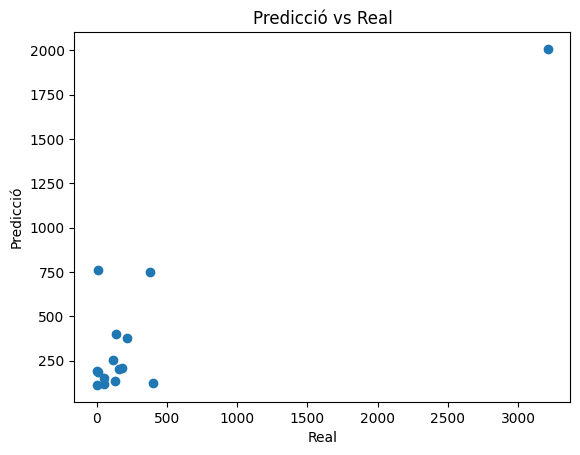

In [32]:
from sklearn.metrics import mean_squared_error, r2_score

X_test = scaler.transform(X_test)
X_test_filtrat = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)[coef_significatius.index]


y_test_pred = best_model.predict(X_test_filtrat)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()